In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.9.1+cpu
CUDA available: False


In [2]:
import zipfile
import os

ZIP_PATH = "all_satellite_images.zip"      # path to zip file
EXTRACT_DIR = "atellite_images"       # output folder

os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Extraction complete")
print("Total files extracted:", len(os.listdir(EXTRACT_DIR)))

Extraction complete
Total files extracted: 1


In [3]:
INNER_DIR = os.path.join("atellite_images", os.listdir("atellite_images")[0])
print("Inner directory:", INNER_DIR)
print("Number of files inside:", len(os.listdir(INNER_DIR)))

Inner directory: atellite_images\images
Number of files inside: 16209


LOAD DATA & BASIC GEO-VISUAL EDA

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train(1).csv")

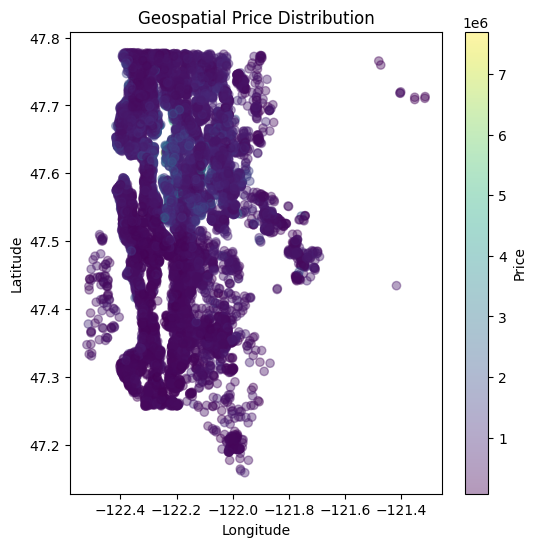

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(df["long"], df["lat"], c=df["price"], alpha=0.4)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Price Distribution")
plt.show()

IMAGE-LEVEL VISUAL EDA (WATER / DENSITY PROXY)

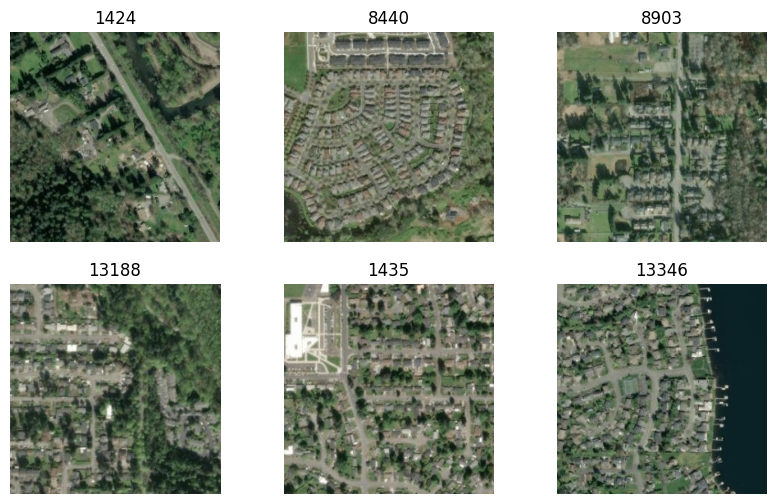

In [6]:
from PIL import Image
import random

sample_imgs = random.sample(os.listdir(INNER_DIR), 6)

plt.figure(figsize=(10,6))
for i, img_name in enumerate(sample_imgs):
    img = Image.open(os.path.join(INNER_DIR, img_name))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name.split(".")[0])
plt.show()

BASIC VISUAL FEATURE PROXIES

In [7]:
import cv2
import numpy as np
import os

def visual_proxies(img_path):
    # Skip if not a file
    if not os.path.isfile(img_path):
        return None, None

    img = cv2.imread(img_path)

    # Skip unreadable images
    if img is None:
        return None, None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    green = np.sum(
        (hsv[:, :, 1] > 40) &
        (hsv[:, :, 0] > 35) &
        (hsv[:, :, 0] < 85)
    )

    blue = np.sum(
        (hsv[:, :, 0] > 90) &
        (hsv[:, :, 0] < 130)
    )

    total = img.shape[0] * img.shape[1]

    return green / total, blue / total

In [8]:
greens, blues = [], []

for fname in os.listdir(INNER_DIR):
    g, b = visual_proxies(os.path.join(INNER_DIR, fname))
    greens.append(g)
    blues.append(b)

df["green_ratio"] = greens[:len(df)]
df["water_ratio"] = blues[:len(df)]

In [9]:
df[["green_ratio", "water_ratio", "price"]].corr()

,green_ratio,water_ratio,price
green_ratio,1.000000,-0.080536,0.006904
water_ratio,-0.080536,1.000000,-0.005671
price,0.006904,-0.005671,1.000000


**CNN FEATURE EXTRACTION**

Load pretrained CNN

In [10]:
import torchvision.models as models
import torchvision.transforms as transforms

Image preprocessing

In [11]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Extract image embeddings

In [12]:
from PIL import Image, UnidentifiedImageError
import os

In [13]:
def extract_embedding(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
    except UnidentifiedImageError:
        return None   # invalid image
    except Exception:
        return None   # any unexpected issue

    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = cnn(img)

    return emb.squeeze().cpu().numpy()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.nn as nn
cnn = models.resnet18(pretrained=True)
cnn.fc = nn.Identity()
cnn = cnn.to(device)
cnn.eval()

C:\Users\shraw\.conda\envs\satellite_ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shraw\.conda\envs\satellite_ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
image_embeddings = {}
bad_images = []

for idx, row in df.iterrows():
    img_path = os.path.join(INNER_DIR, f"{idx}.png")

    if not os.path.exists(img_path):
        continue

    emb = extract_embedding(img_path)

    if emb is None:
        bad_images.append(idx)
        continue

    image_embeddings[row["id"]] = emb

In [16]:
list(image_embeddings.keys())[:10]

[9117000170,
 6700390210,
 7212660540,
 8562780200,
 7760400350,
 464001025,
 3432500486,
 1126059095,
 3876500290,
 2558690150]

In [17]:
df_fusion = df[df["id"].isin(image_embeddings.keys())].copy()

In [18]:
img_features = np.vstack(
    [image_embeddings[i] for i in df_fusion["id"]]
)

TABULAR FEATURES (BASELINE)

In [19]:
from sklearn.preprocessing import StandardScaler

tabular_features = [
    "bedrooms","bathrooms","sqft_living","floors",
    "view","grade","sqft_above","sqft_basement",
    "lat","sqft_living15"
]

X_tab = df[tabular_features]
y = np.log1p(df["price"])

scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab)

**FUSION ARCHITECTURES**

EARLY FUSION

In [20]:
X_tab_fusion = X_tab_scaled[df_fusion.index]

In [21]:
X_early = np.hstack([X_tab_fusion, img_features])

In [22]:
print(X_tab_fusion.shape)
print(img_features.shape)
print(X_early.shape)

(16208, 10)
(16208, 512)
(16208, 522)


In [86]:
y_fusion = np.log1p(df_fusion["price"].values)

In [87]:
print(X_early.shape)
print(y_fusion.shape)

(16208, 522)
(16208,)


In [88]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_tr, X_va, y_tr, y_va = train_test_split(
    X_early, y_fusion, test_size=0.2, random_state=42
)

model_early = XGBRegressor(
    n_estimators=300, max_depth=6, learning_rate=0.05
)
model_early.fit(X_tr, y_tr)

pred = model_early.predict(X_va)
rmse_early = np.sqrt(mean_squared_error(y_va, pred))
r2_early = r2_score(y_va, pred)

print(rmse_early, r2_early)

0.19056463015655456 0.8688354462113618


LATE FUSION

In [89]:
# Tabular only
model_tab = XGBRegressor(n_estimators=300, max_depth=5)
model_tab.fit(X_tab_scaled, y)

# Tabular features aligned to fusion rows
X_tab_fusion = X_tab_scaled[df_fusion.index]

# Predict using tabular-only model
tab_preds_fusion = model_tab.predict(X_tab_fusion)

# Image only (simple regressor)
model_img = XGBRegressor(n_estimators=200, max_depth=4)
model_img.fit(img_features, y_fusion)

img_preds = model_img.predict(img_features)

In [90]:
# Meta-learner
fusion_X = np.vstack([tab_preds_fusion, img_preds]).T

meta = XGBRegressor(n_estimators=200, max_depth=3)
meta.fit(fusion_X, y_fusion)

fusion_preds = meta.predict(fusion_X)

mse_late = mean_squared_error(y_fusion, fusion_preds)
rmse_late = np.sqrt(mse_late)
r2_late = r2_score(y_fusion, fusion_preds)

print(rmse_late, r2_late)

0.12500967285616238 0.9430574096004716


FINAL COMPARISON

In [91]:
pd.DataFrame({
    "Model": ["Tabular Only", "Early Fusion", "Late Fusion"],
    "R2": [
        model_tab.score(X_tab_scaled, y),
        r2_early,
        r2_late
    ]
})

,Model,R2
0,Tabular Only,0.961122
1,Early Fusion,0.868835
2,Late Fusion,0.943057


Train–Validation Split (Fusion Features)

In [96]:
from sklearn.model_selection import train_test_split

y_fusion = np.log1p(df_fusion["price"].values)

X_train, X_val, y_train, y_val = train_test_split(X_early, y_fusion, test_size=0.2, random_state=4)

In [99]:
y_val

array([12.93603621, 12.20607765, 13.38472918, ..., 12.59473403,
       14.06627005, 13.42320992], shape=(3242,))

In [97]:
fusion_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

fusion_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Evaluate Fusion Model on Validation dataset

In [101]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_log_pred = fusion_model.predict(X_val)
y_pred = np.expm1(y_log_pred)

y_log_pred

array([13.204908, 12.032735, 13.169269, ..., 12.635576, 14.134159,
       13.341857], shape=(3242,), dtype=float32)

In [103]:
rmse = np.sqrt(mean_squared_error(y_val, y_log_pred))
r2 = r2_score(y_val, y_log_pred)

print("Fusion Model RMSE:", rmse)
print("Fusion Model R2:", r2)

Fusion Model RMSE: 0.1966849585668217
Fusion Model R2: 0.8606682012293856


Predictions

In [32]:
test_df = pd.read_csv("test2.csv")
test_df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [33]:
test_df[tabular_features]

,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_above,sqft_basement,lat,sqft_living15
0,4,2.25,2070,2.0,0,8,2070,0,47.4388,2390
1,5,3.00,2900,1.0,0,8,1830,1070,47.6784,2370
2,4,2.50,3770,2.0,2,11,3770,0,47.5646,3710
3,3,3.50,4560,2.0,2,12,4560,0,47.6995,4050
4,3,2.50,2550,2.0,0,9,2550,0,47.6647,2250
...,...,...,...,...,...,...,...,...,...,...
5399,4,2.50,2820,2.0,0,9,2820,0,47.7255,2440
5400,3,2.00,1460,1.5,0,7,1460,0,47.6693,1690
5401,3,2.50,2070,1.0,0,8,1420,650,47.2988,2070
5402,4,2.25,4760,2.5,0,9,3390,1370,47.6415,2950


Loading test images

In [34]:
import zipfile
import os

ZIP_PATH_test = "TEST_IMAGES_DATA.zip"      # path to zip file
EXTRACT_DIR_test = "TEST_IMAGES_DATA"       # output folder

os.makedirs(EXTRACT_DIR_test, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH_test, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_DIR_test)

print("Extraction complete")
print("Total files extracted:", len(os.listdir(EXTRACT_DIR_test)))

Extraction complete
Total files extracted: 1


In [35]:
def find_image_directory(root_dir, extensions=(".png", ".jpg", ".jpeg")):
    for root, dirs, files in os.walk(root_dir):
        img_files = [f for f in files if f.lower().endswith(extensions)]
        if len(img_files) > 0:
            return root, img_files
    return None, []

In [36]:
INNER_DIR_test, image_files = find_image_directory(EXTRACT_DIR_test)

print("Final image directory:", INNER_DIR_test)
print("Number of images found:", len(image_files))

Final image directory: TEST_IMAGES_DATA\content\esri_images
Number of images found: 5396


In [37]:
import os

image_ids = set(
    int(os.path.splitext(f)[0])
    for f in os.listdir(INNER_DIR_test)
    if f.endswith(".png")
)

print("Total images found:", len(image_ids))

Total images found: 5396


In [38]:
test_df["id"] = test_df["id"].astype(int)

In [39]:
initial_rows = len(test_df)

test_df = test_df[test_df["id"].isin(image_ids)].reset_index(drop=True)

final_rows = len(test_df)

print("Initial test tabular rows:", initial_rows)
print("Rows after image alignment:", final_rows)
print("Rows dropped:", initial_rows - final_rows)

Initial test tabular rows: 5404
Rows after image alignment: 5404
Rows dropped: 0


In [40]:
duplicate_ids = test_df["id"].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids > 1]

print("Number of duplicated IDs:", len(duplicate_ids))
duplicate_ids.head()

Number of duplicated IDs: 8


id
7504021310    2
7853420110    2
3969300030    2
9211500620    2
4202400078    2
Name: count, dtype: int64

In [41]:
initial_rows = len(test_df)

test_df = test_df[test_df["id"].isin(image_ids)]
test_df = test_df.drop_duplicates(subset="id")

test_df = test_df.reset_index(drop=True)

final_rows = len(test_df)

print("Initial test tabular rows:", initial_rows)
print("Unique image IDs:", len(image_ids))
print("Rows after alignment & deduplication:", final_rows)
print("Rows dropped:", initial_rows - final_rows)

Initial test tabular rows: 5404
Unique image IDs: 5396
Rows after alignment & deduplication: 5396
Rows dropped: 8


In [42]:
from PIL import Image
import traceback

image_embeddings_test = {}
bad_images = []

for idx in test_df["id"]:
    img_path = os.path.join(INNER_DIR_test, f"{idx}.png")

    try:
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            emb = cnn(img_tensor)

        image_embeddings_test[idx] = emb.squeeze().cpu().numpy()

    except Exception as e:
        print(f"FAILED for image ID {idx}")
        print("Image path:", img_path)
        traceback.print_exc()
        break   

In [43]:
print("Embeddings created:", len(image_embeddings_test))
print("Bad images:", len(bad_images))

assert len(image_embeddings_test) == len(test_df)

Embeddings created: 5396
Bad images: 0


In [44]:
img_features_test = np.vstack(
    [image_embeddings_test[i] for i in test_df["id"]]
)

print("Image features shape:", img_features_test.shape)

Image features shape: (5396, 512)


In [45]:
X_test_tabular = test_df[tabular_features]
print(test_df[tabular_features])
X_test_tabular_scaled = scaler.transform(X_test_tabular)

      bedrooms  bathrooms  sqft_living  floors  view  grade  sqft_above  \
0            4       2.25         2070     2.0     0      8        2070   
1            5       3.00         2900     1.0     0      8        1830   
2            4       2.50         3770     2.0     2     11        3770   
3            3       3.50         4560     2.0     2     12        4560   
4            3       2.50         2550     2.0     0      9        2550   
...        ...        ...          ...     ...   ...    ...         ...   
5391         4       2.50         2820     2.0     0      9        2820   
5392         3       2.00         1460     1.5     0      7        1460   
5393         3       2.50         2070     1.0     0      8        1420   
5394         4       2.25         4760     2.5     0      9        3390   
5395         4       1.75         1720     1.0     0      8        1720   

      sqft_basement      lat  sqft_living15  
0                 0  47.4388           2390  
1      

In [46]:
X_test_final = np.hstack([
    X_test_tabular_scaled,
    img_features_test
])

print("Final test feature shape:", X_test_final.shape)

Final test feature shape: (5396, 522)


In [47]:
predicted_price = fusion_model.predict(X_test_final)

In [ ]:
predicted_price

In [48]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": predicted_price
})

In [50]:
submission.head(5)

,id,predicted_price
0,2591820310,4.215734e+05
1,7974200820,8.740766e+05
2,7701450110,1.708803e+06
3,9522300010,1.654710e+06
4,9510861140,9.466549e+05


In [51]:
submission.to_csv(
    "final_price_predictions.csv",
    index=False
)

Baseline vs Multimodal Model Comparison

In [105]:
rmse_tabular =0.22784790171763092 
rmse_multimodal = 0.1966849585668217
r2_tabular=0.8118718176866792
r2_multimodal =0.8606682012293856

In [106]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Tabular Only", "Tabular + Satellite Images"],
    "RMSE": [rmse_tabular, rmse_multimodal],
    "R2 Score": [r2_tabular, r2_multimodal]
})

comparison_df

,Model,RMSE,R2 Score
0,Tabular Only,0.227848,0.811872
1,Tabular + Satellite Images,0.196685,0.860668


Grad-CAM Implementation

In [55]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [56]:
target_layer = cnn.layer4[-1]

In [78]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)

        # Regression → use output directly
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


In [79]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = torch.tensor(img).permute(2, 0, 1).float().unsqueeze(0)
    return img

In [80]:
def overlay_cam(img_path, cam):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return overlay

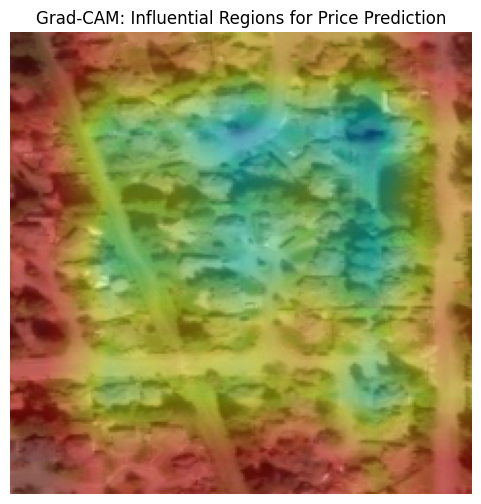

In [81]:
gradcam = GradCAM(cnn, target_layer)

import random
img = os.path.join(INNER_DIR_test, random.choice(image_files))
# any test image
input_tensor = preprocess_image(img)
cam = gradcam.generate(input_tensor)

overlay = overlay_cam(img, cam)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM: Influential Regions for Price Prediction")
plt.show()